# <i>Kepler</i> observations of complex rotator KIC 6102338


### Set up <tt>python</tt> environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy
from astropy.timeseries import LombScargle
import scipy.optimize as sopt
from scipy.optimize import minimize

# Load our software package
import sys
sys.path.append('..')
from RedNoiseFALs import RedNoiseFALs 

plt.rcParams.update({"font.size":16, "axes.labelsize":16, "font.family":"sans-serif", "font.sans-serif":"Arial"})

### Read the dataset using pandas


This demonstration uses the <i>Kepler</i> Q3 observations of an active M dwarf KIC 6102338, <a href="https://ui.adsabs.harvard.edu/abs/2020yCat.1350....0G/abstract">Gaia Collaboration (2020)</a>, these calculations are featured in section 4.4 of our paper.

In [2]:
data = pd.read_csv('KIC6102338_rotatingstar.txt',sep ="\s+",comment="#")
data.head()

,BJD,Flux
0,2.455093e+06,10024.027344
1,2.455093e+06,10024.592773
2,2.455093e+06,10026.798828
3,2.455093e+06,10019.708008
4,2.455093e+06,10012.664062


The activity indicator $\log (R^{\prime}_{HK})$ timeseries is employed for this demo. These calculations are featured in Section 4.1 of our paper.

In [3]:
time = np.array(data['BJD'])
obs = np.array(data["Flux"])
eobs = obs*10**-4


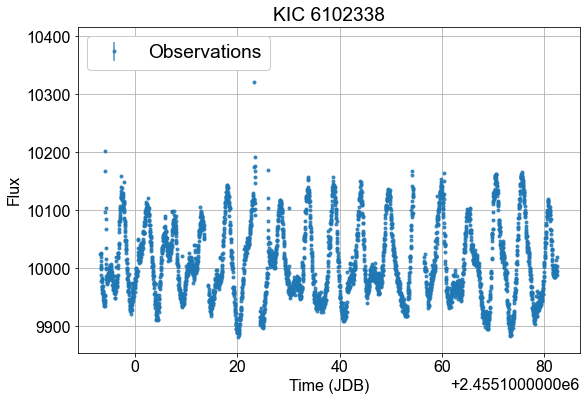

In [4]:
plt.figure(figsize=(9,6))
plt.title(r"KIC 6102338")
plt.errorbar(time, obs, yerr=eobs, fmt='.', ls=None, alpha=0.8,label= "Observations")
plt.xlabel("Time (JDB)")
plt.ylabel(r'Flux')
plt.tick_params(axis='y')
plt.grid(axis="both")
plt.legend(loc='upper left',fontsize='large', ncol=1, facecolor='white', framealpha=1)

We've to normalize the time series so that it has a median time step of 1 day. This is necessary to fit an AR(1) model.

In [5]:
time = time/np.median(np.diff(time))

### Calculate the LombScargle periodogram 

We cut a few initial grid points in this case to exclude the initial part of the power spectrum that has positive slope. 

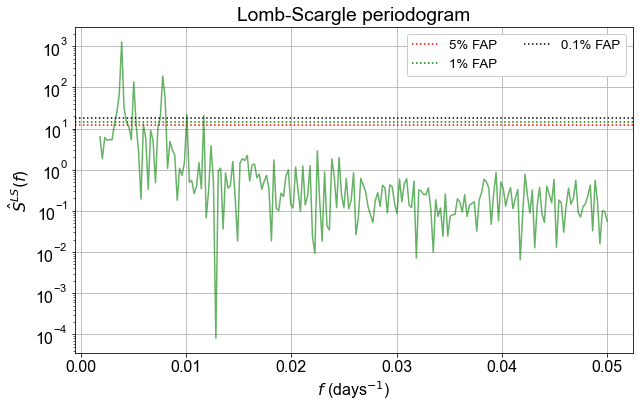

In [6]:
fmax = 0.05
rnf = RedNoiseFALs(time,obs,eobs,fmax,fmin=0.0018)

### Fitting the noise models

#### 1. AR(1) fit

----------------------- AR(1) FITTING RESULTS -------------------
Optimization terminated successfully.
Phi = 1.00
Sigma = 0.14
Whittle negative log-likelihood = 230.44


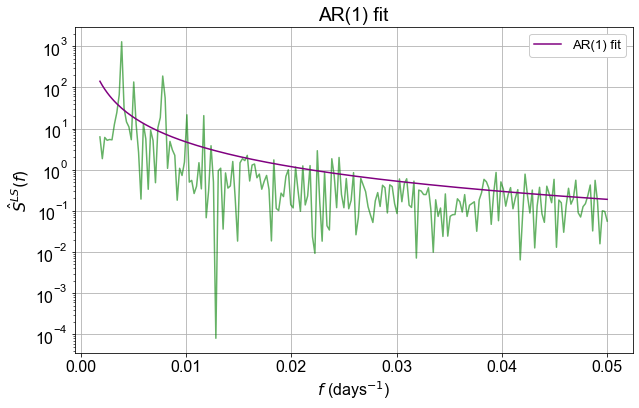

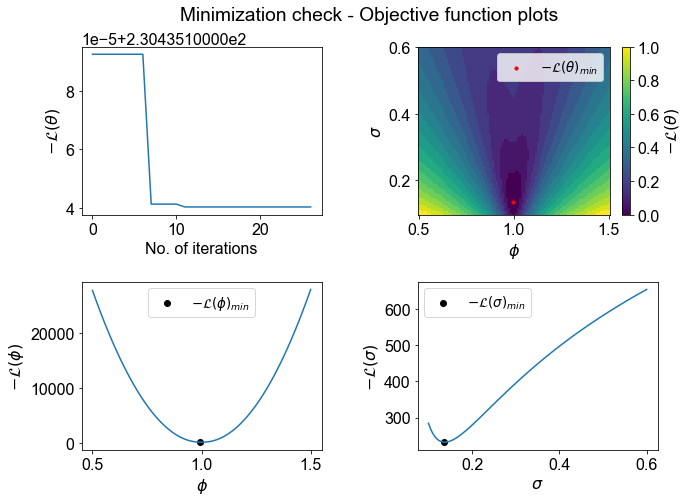

In [7]:
ar = rnf.ar1_fit([0.999999,0.14],plot_limits=[(0.5,1.5),(0.1,0.6)])


#### 2. Power law fit

----------------------- POWER LAW FITTING RESULTS -------------------
Optimization terminated successfully.
Slope = -2.53
Intercept = -4.27
Whittle negative log-likelihood = 206.47


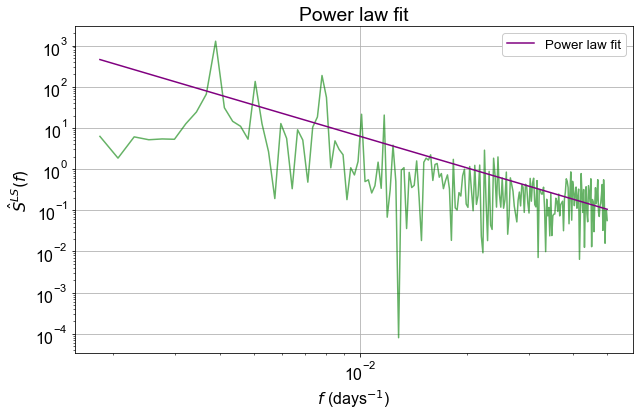

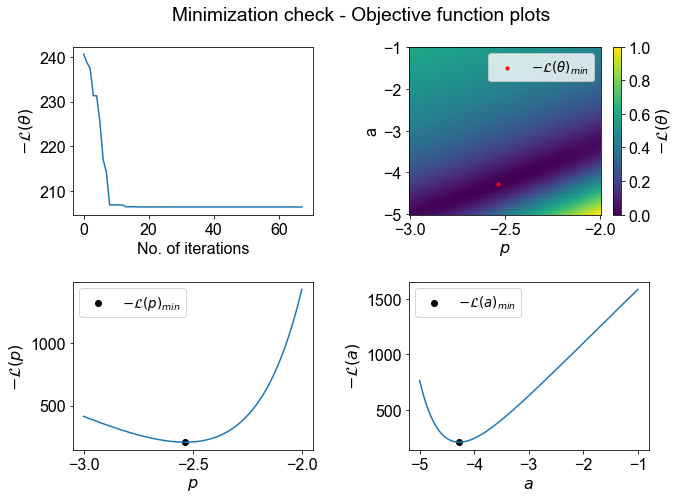

In [8]:
pl = rnf.pl_fit([-2,-3],plot_limits=[(-3,-2),(-5,-1)])


#### 3. White noise fit

----------------------- WHITE NOISE FITTING RESULTS -------------------
Optimization terminated successfully.
Power of white noise = 9.74
Whittle negative log-likelihood = 691.35


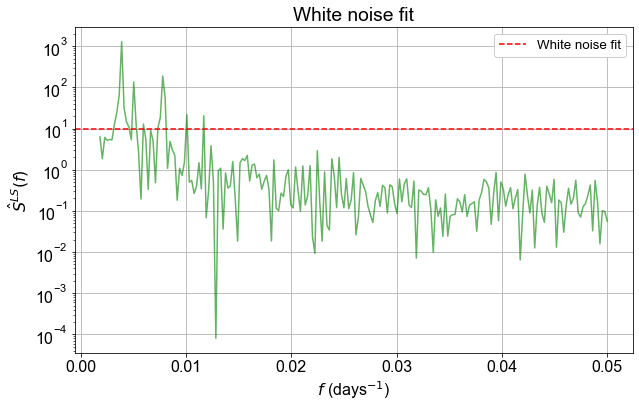

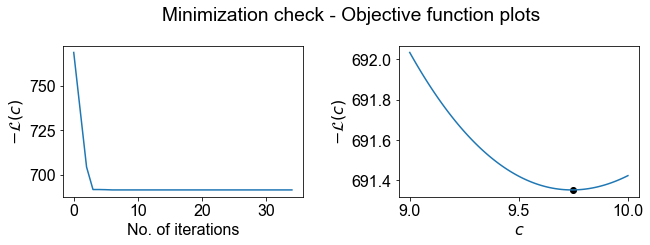

In [9]:
wn = rnf.wn_fit(4.0,plot_limits=[(9,10)])



### Choosing the best model type

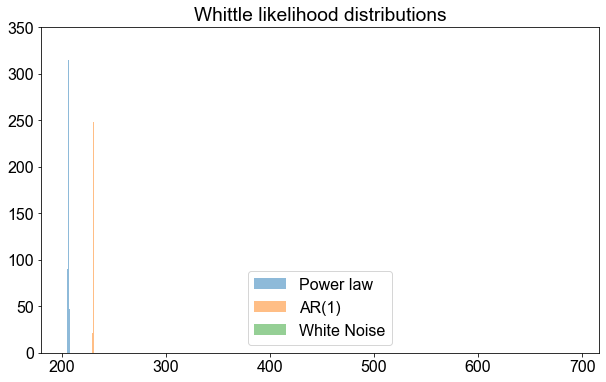

In [10]:

dist= rnf.gen_distributions(n_bootstrap=10000,save_file="Demo_KIC.txt")



(650.0, 750.0)

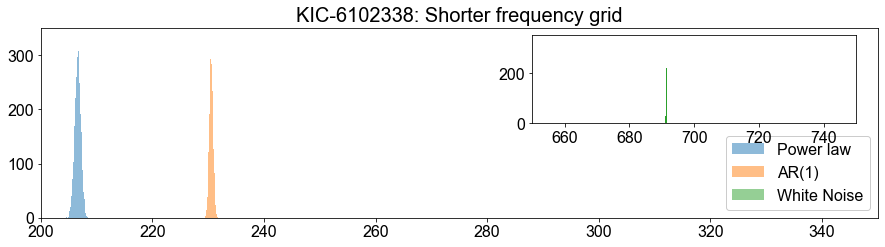

In [11]:
save_file = "Demo_KIC.txt"
dist = pd.read_csv(save_file,delim_whitespace=True,)
pd.set_option('display.float_format', lambda x: f'{x:.20f}')

dist_pl = dist["WNLL_PL"]
dist_ar1 = dist["WNLL_AR1"]
dist_wn = dist["WNLL_WN"]

bins = 100
plt.figure(figsize=(15,3.5))
plt.title("KIC-6102338: Shorter frequency grid",fontsize=20)
plt.hist(dist_pl,label="Power law",alpha =0.5,bins=bins)
plt.hist(dist_ar1,label="AR(1)",alpha =0.5,bins=bins)
plt.hist(dist_wn,label="White Noise",alpha =0.5,bins=bins)
plt.xlim(200,350)
plt.legend(loc='lower right',fontsize='medium', ncol=1, facecolor='white', framealpha=1)

ax_zoom = plt.axes([0.58, 0.5, 0.3, 0.35])  # [left, bottom, width, height]
ax_zoom.hist(dist_pl,label="Power law",bins=bins);
ax_zoom.hist(dist_ar1,label="AR(1)",bins=bins);
ax_zoom.hist(dist_wn,label="White Noise",bins=bins);
ax_zoom.set_xlim(650,750)


In this case, the power law is the best-fit model.

### Calculating the FALs

In [12]:
slope = dist["Slope"]
intercept = dist["Intercept"]

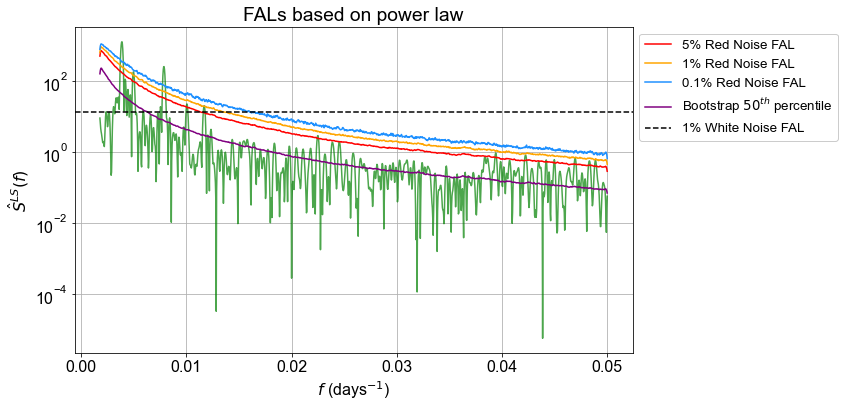

In [13]:
# We get the distribution of parameters to calculate the FALs

fals_pl = rnf.fal_pl(slope,intercept)